# Cortical Magnification Tutorial


**Author**: &nbsp;&nbsp; [Noah C. Benson](mailto:nben@nyu.edu)  
**Date**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Jan. 10, 2020  
**Link**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [noahbenson/cortical-magnification-tutorial](https://github.com/noahbenson/cortical-magnification-tutorial)


## Introduction

This notebook is intended as an introduction to cortical magnification and how it is calculated. When run in its relevant docker-image, with correctly configured HCP credentials (or with additional data that has been configured correctly), it should be possible to use this notebook to calculate and export cortical magnification values for any subject whose retinotopic maps (pRF parameters) have been solved via a pRF solver such as [analyzePRF](https://kendrickkay.net/analyzePRF/), [Vistasoft](https://github.com/vistalab/vistasoft), or [Popeye](https://github.com/kdesimone/popeye).

### What is cortical magnification?

The cortical magnification function (CMF) is the function $f(\mathbf{u}) = m$ where $\mathbf{u}$ is the $(x,y)$ position in the visual field (typically in degrees of visual angle), and $m$ is the number of mm$^2$ of cortex per deg$^2$ of the visual field at that point in the visual field. Accordingly, a high cortical magnification, e.g. $m(\mathbf{u})$ = 150 mm$^2$/deg$^2$, indicates that there is a lot of cortex devoted to a relatively small amount of the visual field, while a low value indicates that very little cortical surface is devoted to that part of the visual field. In the human visual system, the fovea tends to have a cortical magnification that is many times larger than that of the periphery.

Occasionally, cortical magnification is also reported in terms of mm/deg--linear cortical magnification. This is the form a measurement would take if, for example, we measured the length (in mm) of the 5° iso-eccentricity contour across the surface of V1 then divided it by the length of the equivalent 5° iso-eccentricity arc in the visual field ($\pi/2 \times 5° \approx 7.85°$). When cortical magnification is in units of mm/deg, it typically is measuring the magnification in a particular direction such as tangential (around the visual field) or radial (toward/from the fovea). In the case of the 5° iso-eccentricity arc, the direction would be tangential.

### Tutorial Setup

#### Import and Configure Libraries

To run this tutorial, we must have a few things configured. First, we should start by importing a few relevant libraries.

In [1]:
# Import some standard/utility libraries:
import os, sys, time, h5py, zipfile
import six           # six provides python 2/3 compatibility

# Import our numerical/scientific libraries, scipy and numpy:
import numpy as np
import scipy as sp

# The pimms (Python Immutables) library is a utility library that enables lazy
# computation and immutble data structures; https://github.com/noahbenson/pimms
import pimms

# The neuropythy library is a swiss-army-knife for handling MRI data, especially
# anatomical/structural data such as that produced by FreeSurfer or the HCP.
# https://github.com/noahbenson/neuropythy
import neuropythy as ny

# Import graphics libraries:
# Matplotlib/Pyplot is our 2D graphing library:
import matplotlib as mpl
import matplotlib.pyplot as plt
# We also use the 3D graphics library ipyvolume for 3D surface rendering
import ipyvolume as ipv

##### Configure matplotlib for 2D plotting:

In [2]:
# These "magic commands" tell matplotlib that we want to plot figures inline and
# That we are using qt as a backend; due to bugs in certain versions of
# matplotlib, we put them in a separate cell from the import statements above
# and the configuration statements below.
%gui qt
%matplotlib inline

In [3]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['Helvetica Neue', 'Helvetica', 'Arial'],
             'size': 10,
             'weight': 'light'}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72*2
mpl.rcParams['savefig.dpi'] = 72*4

#### Configure neuropythy's HCP interface, if not done automatically:

Note: If you intend to use a custom subject and set of pRF measurements with this notebook instead of using an HCP subject, you can skip this section.

The [neuropythy](https://github.com/noahbenson/neuropythy) library can easily be configured to automatically download HCP data it is requested. In order to do this, however, it must have been given a set of HCP credentials. The HCP uses the Amazon S3 so these credentials are in the form of a "key" and a "secret". To obtain HCP credentials, you must register at the [HCP database website](https://db.humanconnectome.org/) then generate Amazon S3 credentials through their interface. The [neuropythy configuration documentation](https://github.com/noahbenson/neuropythy/wiki/Configuration) explains how to do this in more detail.

Your credentials will look something like "`AKAIG8RT71SWARPYUFUS`" and "`TJ/9SJF+AF3J619FA+FAE83+AF3318SXN/K31JB19J4`" (key and secret). They are often printed with a "`:`" between them like "`AKAIG8RT71SWARPYUFUS:TJ/9SJF+AF3J619FA+FAE83+AF3318SXN/K31JB19J4`". If, when you started up the docker-container running this notebook, you provided your credentials as a `:`-separated string like this via the environment variable HCP_CREDENTIALS, you should be fine. If neuropythy found your credentials, they should be in neuropythy's `config` structure, which behaves like a Python dictionary. However, if you are running this tutorial in the Neurohackademy 2019 class itself, you likely were not able to do this and will have to set these credentials manually. If neuropythy could not read your credentials or if they were not set, then `ny.config['hcp_credentials']` will be `None`. If this is the case, you can either:
 * set the credentials directly in this notebook by running something like:  
   ```python
   key = 'AKAIG8RT71SWARPYUFUS'
   secret = 'TJ/9SJF+AF3J619FA+FAE83+AF3318SXN/K31JB19J4'
   ny.config['hcp_credentials'] = (key, secret)
   ```
 * restart the docker container after configuring the `HCP_CREDENTIALS` environment variable:
   ```bash
   > export HCP_CREDENTIALS="AKAIG8RT71SWARPYUFUS:TJ/9SJF+AF3J619FA+FAE83+AF3318SXN/K31JB19J4"
   > docker-compose up
   ```
 * store the credentials in a local file and import its contents into the `HCP_CREDENTIALS` environment variable:
   ```bash
   > echo "AKAIG8RT71SWARPYUFUS:TJ/9SJF+AF3J619FA+FAE83+AF3318SXN/K31JB19J4" > ~/.hcp-passwd
   > export HCP_CREDENTIALS="`cat ~/.hcp-passwd`"
   > docker-compose up
   ```

We also want to check that neuropythy was able to connect to the HCP database. If this fails, it is possible that either your credentials are incorrect/expired or that you do not have a valid internet connection, or that you did something unexpected when mounting volumes into the docker that prevent neuropythy from knowing where to store the HCP data (unlikely).

In [4]:
# Check that HCP credentials were found:
if ny.config['hcp_credentials'] is None:
    raise Exception('No valid HCP credentials were found!\n'
                    'See above instructions for remedy.')

# Check that we can access the HCP database:
# To do this we grab the 's3fs' object from neuropythy's 'hcp' dataset; this
# object maintains a connection to Amazon's S3 using the hcp credentials. We use
# it to perform a basic ls operation on the S3 filesystem. If this fails, we do
# not have a working connection to the S3.
try: files = ny.data['hcp'].s3fs.ls('hcp-openaccess')
except Exception: files = None
if files is None:
    raise Exception('Could not communicate with S3!\n'
                    'This probably indicates that your credentials are wrong'
                    ' or that you do not have an internet connection.')

print('Configuration appears fine!')

Configuration appears fine!


Setup a subject and the data we need for cortical magnification. Because we are using an HCP subject, most of this is done for us.

In [ ]:
sid = 177746
sub = ny.hcp_subject(sid)

#### Alternately, configure a custom data source

Note: If you intend to use this notebook with an HCP subject rather than with your own subject, you can skip this section.

As an alternative to using HCP data, you can configure this notebook to work with a separate data source. If you are using this notebook via the docker-image or the docker-compose command, you will have to make sure that the data you wish to load is already mounted into the docker-image when it is run. If you are using `docker-compose up` or `docker run` to start this notebook, you'll need to restart the notebook using `docker run` while giving it some additional arguments. You'll want to provide your FreeSurfer and/or HCP subject directory to the docker-image, and you'll want to provide a directory containing any data files to the docker as well.

Let's assume that you are using a FreeSurfer subject whose path is `/Volumes/server/Freesurfer_subjects/test-sub` and that the data for this subject is in a set of mgz files in the directory `/Users/nben/Data/retinotopy/test-sub`. You would want to start the docker-image with the following command.

```bash
> docker run --rm -it \
     -v /Volumes/server/Freesurfer_subjects/test-sub:/subjects/test-sub \
     -v /Users/nben/Data/retinotopy/test-sub:/data/test-sub \
     -v "${PWD}/work":/home/jovyan/work \
     -p 8765:8765 \
     nben/neuropythy:latest notebook
```

This makes the `/Volumes/server/Freesurfer_subjects/test-sub` directory available to this notebook as the `/subjects/test-sub` directory and the `/Users/nben/Data/retinotopy/test-sub` directory available as the `/data/test-sub` directory.

In [4]:
# Edit these variables to be appropriate for the data you mounted

# The subject directory and the kind of subject it is
subject_path = '/subjects/test-sub'
subject_type = 'freesurfer' # or 'hcp'
#subject_type = 'hcp' # or 'freesurfer'

# The directory containing the pRF parameters
prf_path = '/data/test-sub'
# how the files are named:
prf_filename_patt = '{hemi}_{prop}.mgz'
# the prf property names as keys, what are the {prop} taks in the file?
prf_props = {'polar_angle':        'angle',
             'eccentricity':       'eccen',
             'radius':             'prfsz',
             'variance_explained': 'vexpl'}

In [5]:
# Load the prf parameters into a map, using the data in the above cell.
prf_params = {}
for hemi in ['lh','rh']:
    tmp = {}
    for (prop, fname_tag) in prf_props.items():
        filename = prf_filename_patt.format(hemi=hemi, prop=fname_tag)
        tmp['prf_' + prop] = ny.load(os.path.join(prf_path, filename))
    prf_params[hemi] = tmp

In [6]:
# Setup a subject with the above data included
if   subject_type == 'freesurfer': sub = ny.freesurfer_subject(subject_path)
elif subject_type == 'hcp':        sub = ny.hcp_subject(subject_path)
else: raise ValueError('Unknown subject_type: %s' % (subject_type,))

lh = sub.lh.with_prop(prf_params['lh'])
rh = sub.rh.with_prop(prf_params['rh'])
sub = sub.copy(hemis=pimms.assoc(sub.hemis, lh=lh, rh=rh))

#### Optional: load in Bayesian Inferred pRF parameters

If you plan to look at meridional ROI-based cortical magnification values, you'll also need to load in inferred maps. These files will need to be added to the docker-image just like the files in the section above. This is true for both FreeSurfer and HCP subjects.

In [7]:
# Edit these variables to be appropriate for the data you mounted

# The directory containing the inferred pRF parameters
inf_path = '/data/inferred/S1202'
# how the files are named:
inf_filename_patt = '{hemi}.99.{prop}_steps=02500_scale=20.00_clip=12_prior=retinotopy.mgz'
# the inferred prf properties:
inf_props = {'polar_angle':  'angle',
             'eccentricity': 'eccen',
             'radius':       'sigma',
             'visual_area':  'varea'}

In [8]:
# Load the inferred prf parameters into a map, using the data in the above cell.
inf_params = {}
for hemi in ['lh','rh']:
    tmp = {}
    for (prop, fname_tag) in inf_props.items():
        filename = inf_filename_patt.format(hemi=hemi, prop=fname_tag)
        tmp['inf_' + prop] = ny.load(os.path.join(inf_path, filename))
    inf_params[hemi] = tmp
    
# Put these properties onto the subject.
lh = sub.lh.with_prop(inf_params['lh'])
rh = sub.rh.with_prop(inf_params['rh'])
sub = sub.copy(hemis=pimms.assoc(sub.hemis, lh=lh, rh=rh))

## How do we measure cortical magnification?

Cortical magnification can be measured in a number of different ways, which tend to converge on the same answer. In this notebook, we will cover four ways that cortical magnification can be estimated:
1. moving ring and spotlight estimation
2. ROI- and path-based estimation
3. triangle-based estimation
4. ellipse-based estimation

Before we dive into these methods, however, let's make a basic flattened 2D projection of the pRF data just to ensure that it is reasonable.

### Quality Control Plots

In [9]:
# The properties we are going to plot:
props = ['prf_polar_angle', 'prf_eccentricity', 'prf_radius']
# The mask we will use:
mask = ('prf_variance_explained', 0.1, np.inf)

# Start by making flatmaps for each hemisphere:
flatmaps = {h: ny.to_flatmap('occipital_pole', sub.hemis[h])
            for h in ('lh', 'rh')}

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


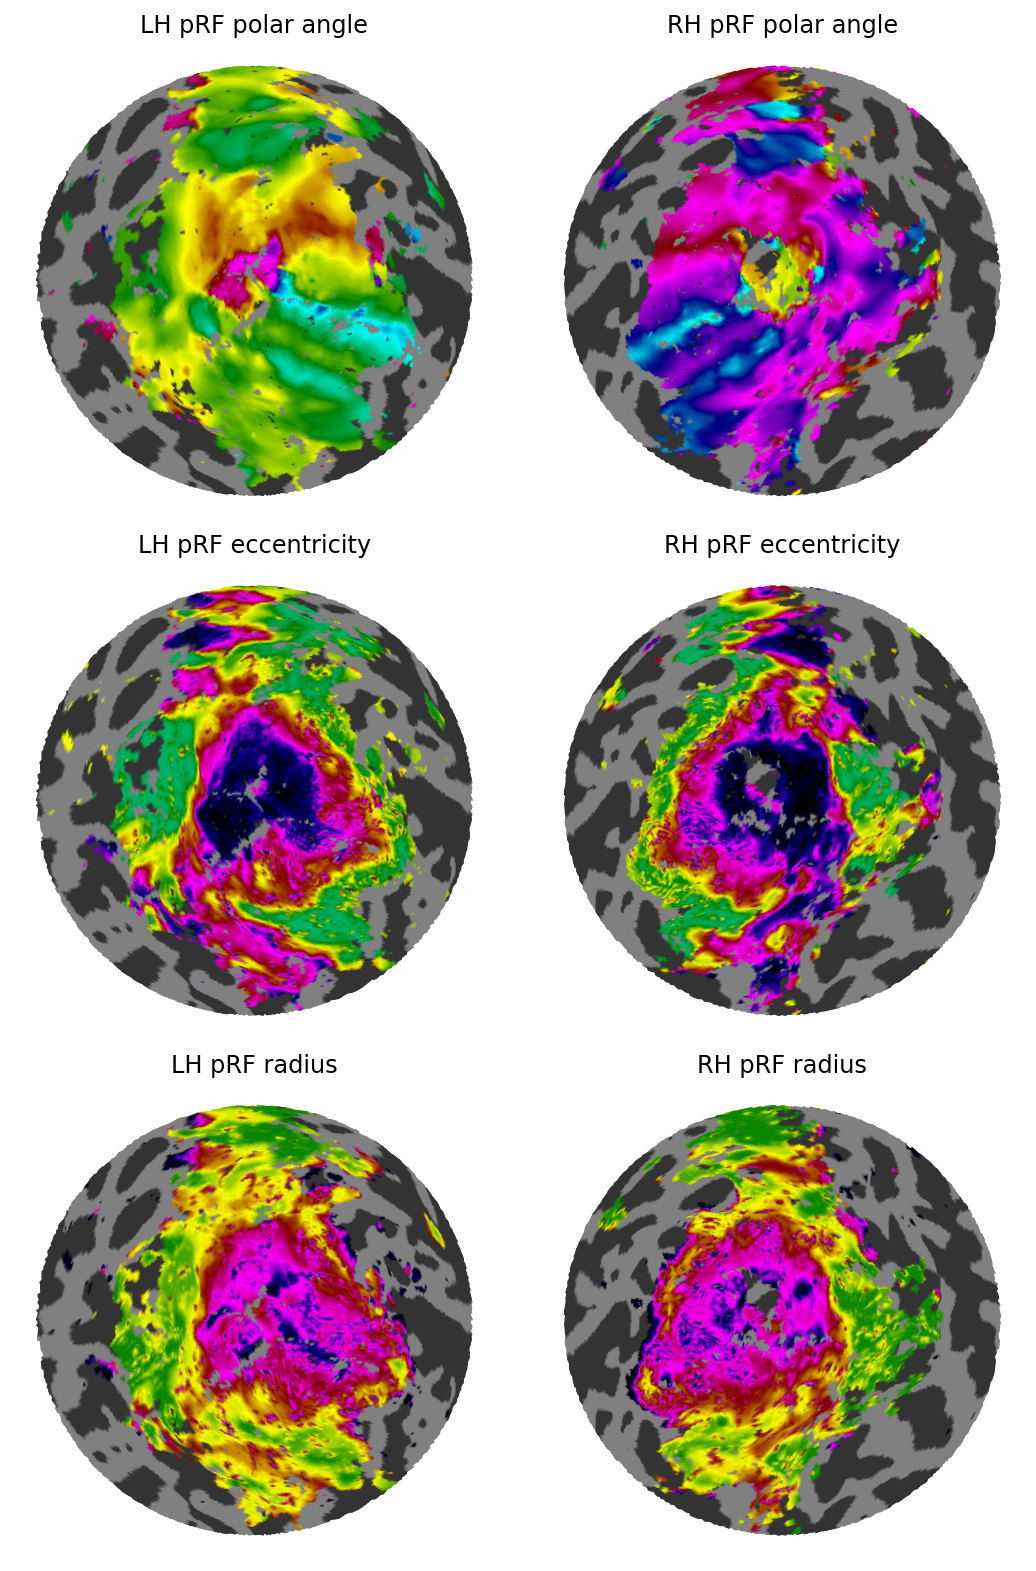

In [10]:
# Next, make the figure:
rs = len(props)
(fig,axs) = plt.subplots(rs,2, figsize=(7, 7*rs/2), dpi=144)
fig.subplots_adjust(0,0,1,1,0.1,0.1)
for ax in axs.flat: ax.axis('off')

# Plot the properties:
for (axrow,prop) in zip(axs, props):
    for (ax,h) in zip(axrow, ['lh','rh']):
        ny.cortex_plot(flatmaps[h], color=prop, mask=mask, axes=ax)
        ax.set_title(h.upper() + ' ' + prop.replace('_', ' ').replace('prf', 'pRF'))

That's one way to plot the pRF parameters--on the cortical surface; another way is to plot them in the visual field. For example, we can take the pRF parameters for each of the vertices in the V1 region (which we can extract using FreeSurfer's V1 label):

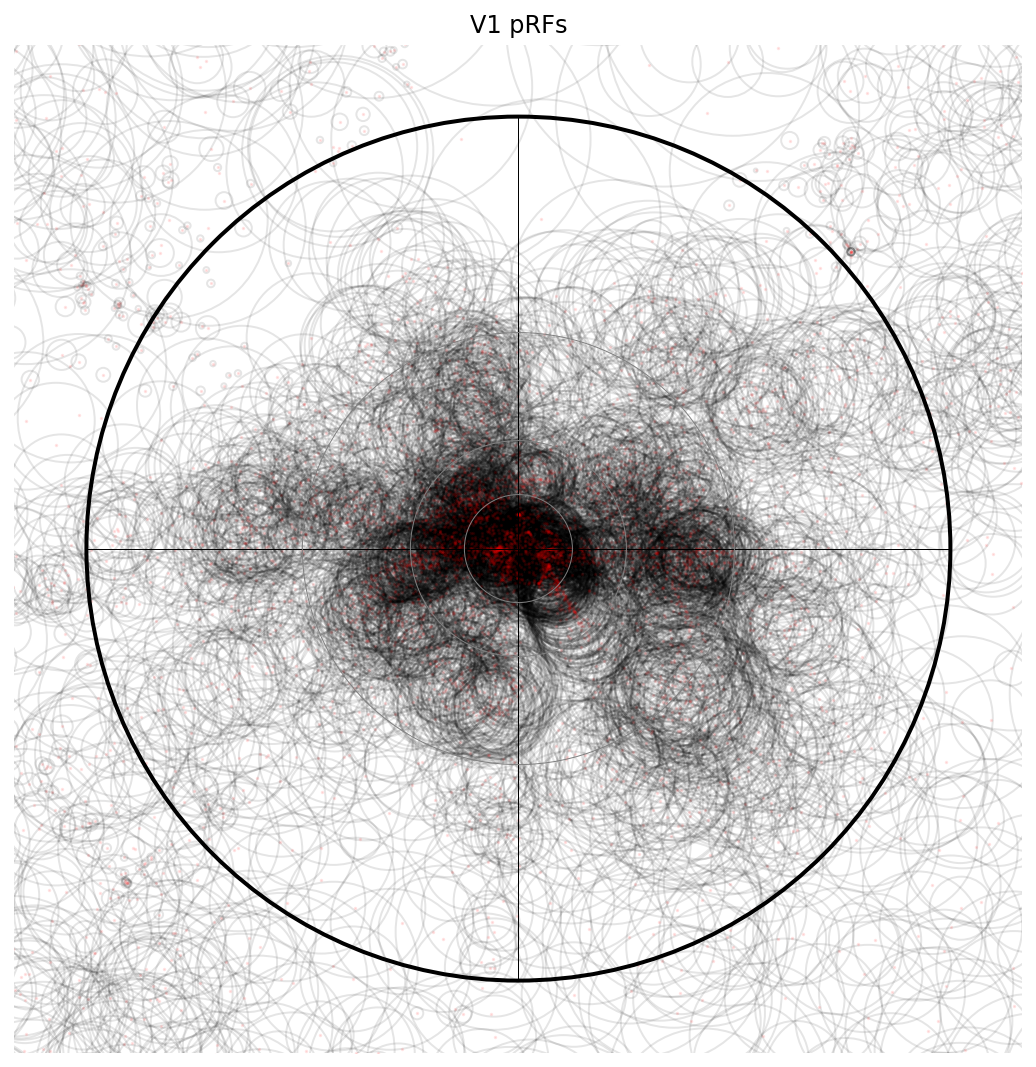

In [29]:
# Setup the figure
(fig,ax) = plt.subplots(1,1, figsize=(7,7), dpi=144)
ax.axis('off')
fig.subplots_adjust(0,0,1,1,0,0)

# Draw the visual field axes:
ax.add_patch(plt.Circle([0,0], 12, fill=True, color='white', zorder=-10))
for rad in [1.5, 3, 6]:
    circ = plt.Circle([0,0], rad, fill=False, color='gray',
                      lw=0.5, zorder=10)
    ax.add_patch(circ)
ax.plot([-12,12],[0,0], 'k-', lw=0.5)
ax.plot([0,0],[-12,12], 'k-', lw=0.5)
ax.add_patch(plt.Circle([0,0], 12, fill=False, ec='black', lw=2, zorder=10))

# Now draw all the pRFs for each hemisphere:
for h in ['lh', 'rh']:
    hemi = sub.hemis[h]
    # convert this hemisphere's prf parameters to x and y
    prf_data = ny.vision.retinotopy_data(hemi, 'prf_')
    (xs,ys) = ny.vision.as_retinotopy(prf_data, 'geographical')
    # get the sigma and variance explained
    sigs = hemi.prop('prf_radius')
    rsqs = hemi.prop('prf_variance_explained')
    # find the pRFs in V1:
    v1 = (hemi.prop('V1_weight') > 0.5) & (rsqs > 0.1)
    # plot each pRF:
    for (x, y, sig, rsq) in zip(xs[v1], ys[v1], sigs[v1], rsqs[v1]):
        disk = plt.Circle([x,y], sig/2, fill=False, fc=None, ec='black',
                          lw=None, alpha=0.1, zorder=0)
        ax.add_patch(disk)
    ax.scatter(xs[v1], ys[v1], s=0.5, c='r', alpha=0.1, zorder=1)
ax.set_title('V1 pRFs')
ax.set_xlim([-14,14])
ax.set_ylim([-14,14]);

### Moving Ring and Spotlight Methods

When cortical magnification is reported, it is often reported as a function of the degrees of eccentricity, e.g., [Horton and Hoyt, 1991](https://doi.org/10.1001/archopht.1991.01080060080030). This is because by far the biggest change in cortical magnification across the visual field covaries with eccentricity.

To calculate the cortical magnification in terms of an eccentricity $r$, a straightforward way is pick some ring of the visual field from eccentricity $r_{<} < r$ to eccentricity $r_{>} > r$ and to count up the total surface area of all the vertices in V1 (or another visual area) that have pRF centers inside the ring, then to divide that area by the area of the ring. Using scipy's spatial hashes, we can do this efficiently for any query; we can even return
quantile data efficiently, as in the following example.

In [77]:
from scipy.spatial import cKDTree as KDTree
# We're going to create a cortical magnification function (in terms of
# eccentricity) for each hemisphere... in order to build this, we will
# want a function that calculates the cortical magnification function
# given an eccentricity and a spatial hash (KDTree) of the vertices in
# V1, hashed on the dimension of eccentricity only.
def cmf(shash, sareas, r):
    # find the 20% of vertices in the hash that are nearest to r
    n = int(np.ceil(shash.n * 0.1))
    # if r is a single or vector of values, reshape it for the query
    r = np.asarray(r)
    rr = (r[None,None] if len(r.shape) == 0 else 
          r[:,None]    if len(r.shape) == 1 else r)
    # make the query:
    iis = shash.query(rr, n)[1] # we only need the indices
    # find the min and max eccentricity of these vertices
    eccs = shash.data[iis,0]
    mnec = np.min(eccs, axis=1)
    mxec = np.max(eccs, axis=1)
    # calculate the area (in deg squared) of the ring
    varea = np.pi / 2 * (mxec**2 - mnec**2)
    # now add up the surface areas of everything inside the ring
    sarea = np.sum(sareas[iis], axis=1)
    # the cortical magnification is the sarea / varea
    return np.reshape(sarea / varea, r.shape)
    
cmag_fn = {}
for h in ['lh', 'rh']:
    hemi = sub.hemis[h]
    # We can start by using a helper function to extract some data relevant
    # to calculating cortical magnification:
    mdat = ny.vision.mag_data(hemi, surface='midgray', mask=('V1_weight', 0.5, 1))
    # we can get the eccentricities of the masked vertices...
    rs = mdat['masked_data']['eccentricity']
    # now we create a spatial hash
    shash = KDTree(rs[:,None])
    # here's the function that calculates the cmag:
    cmag_fn[h] = ny.util.curry(cmf, shash, mdat['surface_areas'])